### WHO data url
https://www.who.int/childgrowth/standards/weight_for_age/en/
#### WHO weight for age txt link
https://www.who.int/childgrowth/standards/wfa_girls_z_exp.txt
<br>https://www.who.int/childgrowth/standards/wfa_girls_p_exp.txt

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

In [2]:
data_girls_percentiles = pd.read_csv('https://www.who.int/childgrowth/standards/wfa_girls_p_exp.txt', sep="\t") #, header=None)
data_girls_percentiles['day'] = data_girls_percentiles['Age']
data_girls_percentiles.head()

,Age,L,M,S,P01,P1,P3,P5,P10,P15,P25,P50,P75,P85,P90,P95,P97,P99,P999,day
0,0,0.3809,3.2322,0.14171,2.002,2.273,2.440,2.532,2.678,2.779,2.932,3.232,3.550,3.729,3.853,4.041,4.166,4.409,4.846,0
1,1,0.3259,3.1957,0.14578,1.963,2.231,2.398,2.490,2.635,2.737,2.892,3.196,3.520,3.704,3.831,4.026,4.155,4.408,4.865,1
2,2,0.3101,3.2104,0.14637,1.972,2.240,2.408,2.500,2.646,2.748,2.904,3.210,3.538,3.723,3.853,4.049,4.181,4.438,4.902,2
3,3,0.2986,3.2315,0.14657,1.986,2.255,2.424,2.516,2.663,2.766,2.923,3.232,3.562,3.749,3.879,4.079,4.212,4.471,4.942,3
4,4,0.2891,3.2558,0.14658,2.004,2.274,2.443,2.536,2.684,2.787,2.945,3.256,3.589,3.778,3.909,4.110,4.245,4.507,4.983,4


In [3]:
max_day = np.max(data_girls_percentiles['day'])

#### LMS z score
https://www.cdc.gov/nchs/data/nhsr/nhsr063.pdf
<br>https://www.indianpediatrics.net/jan2014/jan-37-43.htm
<br> Z score and x-coordinate are same thing
#### scipy.stats.norm
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html

In [4]:
def LMS_z_score(weight_kg, L, M, S):
    if L != 0:
        return 1/(S * L) * ((weight_kg / M) ** L - 1)
    elif L == 0:
        return ln(weight_kg / M)/S
print(LMS_z_score(weight_kg = 10, L = -1, M = 8, S = 5))

def LMS_pdf(weight_kg, L, M, S):
    x = LMS_z_score(weight_kg = weight_kg, L = L, M = M, S = S)
    return scipy.stats.norm.pdf(x = x, loc=0, scale=1)

print(LMS_pdf(weight_kg = 10, L = -1, M = 8, S = 5))

def kg_to_lbs(kg):
    return kg * 2.2046

def lbs_to_kg(lb):
    return lb / 2.2046

0.039999999999999994
0.39862325420460504


In [5]:
baby_weights = pd.read_csv('baby weights.csv')
baby_weights['lbs_2'] = baby_weights['lbs'] + baby_weights['oz'] / 16
baby_weights['kg'] = lbs_to_kg(lb = baby_weights['lbs_2'])
baby_weights = baby_weights.join(data_girls_percentiles[['day', 'L', 'M', 'S']].set_index('day'), on = 'day')

baby_weights

,day,lbs,oz,lbs_2,kg,L,M,S
0,0,7,9,7.5625,3.430327,0.3809,3.2322,0.14171
1,3,6,15,6.9375,3.146829,0.2986,3.2315,0.14657
2,16,8,0,8.0000,3.628776,0.2218,3.6438,0.14258


In [6]:
baby_weights['z_score'] = baby_weights[['kg', 'L', 'M', 'S']].apply(axis = 1,
                                                                    func = lambda in_row: 
                                                                    LMS_pdf(weight_kg = in_row['kg'],
                                                                            L = in_row['L'],
                                                                            M = in_row['M'], 
                                                                            S = in_row['S']))
likelihood_mean = np.mean(baby_weights['z_score'])
print("Mean z_score of baby's weight: " + 
      str(np.round_(likelihood_mean, decimals = 3)) +
     " sigma.")

likelihood_stdev = np.std(baby_weights['z_score'])
print("Standard deviation of baby's weight: " + 
      str(np.round_(likelihood_stdev, decimals = 3)))

baby_weights

Mean z_score of baby's weight: 0.385 sigma.
Standard deviation of baby's weight: 0.015


,day,lbs,oz,lbs_2,kg,L,M,S,z_score
0,0,7,9,7.5625,3.430327,0.3809,3.2322,0.14171,0.364552
1,3,6,15,6.9375,3.146829,0.2986,3.2315,0.14657,0.392501
2,16,8,0,8.0000,3.628776,0.2218,3.6438,0.14258,0.398775


In [7]:
year_5_pdf = pd.DataFrame({'lbs': np.linspace(1, 100, num = 1000)})
year_5_pdf['day'] = max_day
year_5_pdf = year_5_pdf.join(data_girls_percentiles[['day', 'L', 'M', 'S']].set_index('day'), on = 'day')
year_5_pdf['kg'] = lbs_to_kg(lb = year_5_pdf['lbs'])
year_5_pdf['prior_z_score'] = year_5_pdf[['kg', 'L', 'M', 'S']].apply(axis = 1,
                                                                    func = lambda in_row: 
                                                                    LMS_z_score(weight_kg = in_row['kg'],
                                                                                L = in_row['L'],
                                                                                M = in_row['M'], 
                                                                                S = in_row['S']))
for colname in ['L', 'M', 'S', 'kg']:
    del year_5_pdf[colname]

year_5_pdf['likelihood_z_score'] = (year_5_pdf['prior_z_score'] - likelihood_mean) / likelihood_stdev
year_5_pdf['prior_pdf'] = scipy.stats.norm.pdf(x = year_5_pdf['prior_z_score'], loc=0, scale=1)
year_5_pdf['likelihood_pdf'] = scipy.stats.norm.pdf(x = year_5_pdf['likelihood_z_score'], loc=0, scale=1)
year_5_pdf['posterior_pdf'] = year_5_pdf['prior_pdf'] * year_5_pdf['likelihood_pdf']
year_5_pdf['prior_cdf'] = year_5_pdf['prior_pdf'].cumsum(axis = 0)
year_5_pdf['likelihood_cdf'] = year_5_pdf['likelihood_pdf'].cumsum(axis = 0)
year_5_pdf['posterior_cdf'] = year_5_pdf['posterior_pdf'].cumsum(axis = 0)
year_5_pdf['prior_cdf'] = year_5_pdf['prior_cdf'] / np.max(year_5_pdf['prior_cdf'])
year_5_pdf['likelihood_cdf'] = year_5_pdf['likelihood_cdf'] / np.max(year_5_pdf['likelihood_cdf'])
year_5_pdf['posterior_cdf'] = year_5_pdf['posterior_cdf'] / np.max(year_5_pdf['posterior_cdf'])

### check max posterior
print("Max posterior: "+ str(np.max(year_5_pdf['posterior_pdf'])))
year_5_pdf.head()

Max posterior: 0.13559581523908934


,lbs,day,prior_z_score,likelihood_z_score,prior_pdf,likelihood_pdf,posterior_pdf,prior_cdf,likelihood_cdf,posterior_cdf
0,1.000000,1856,-51.272834,-3472.508845,0.0,0.0,0.0,0.0,0.0,0.0
1,1.099099,1856,-48.966315,-3317.462384,0.0,0.0,0.0,0.0,0.0,0.0
2,1.198198,1856,-46.925274,-3180.261576,0.0,0.0,0.0,0.0,0.0,0.0
3,1.297297,1856,-45.100721,-3057.613345,0.0,0.0,0.0,0.0,0.0,0.0
4,1.396396,1856,-43.455616,-2947.027792,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Location of max posterior
max_posterior_lbs = (year_5_pdf
                     .loc[year_5_pdf['posterior_pdf'] == np.max(year_5_pdf['posterior_pdf']), 'lbs']
                     .iloc[0])
max_posterior_lbs

42.91891891891892

#### Helpful intro to matplotlib
https://bespokeblog.wordpress.com/2011/07/07/basic-data-plotting-with-matplotlib-part-2-lines-points-formatting/

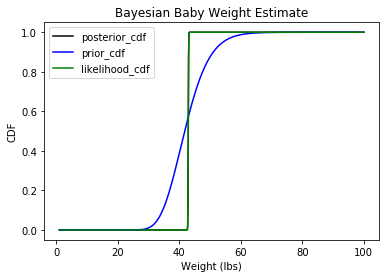

In [9]:
plt.plot(year_5_pdf['lbs'], year_5_pdf['posterior_cdf'], label = 'posterior_cdf',
        linestyle = '-', color = 'k')
plt.plot(year_5_pdf['lbs'], year_5_pdf['prior_cdf'], label = 'prior_cdf',
        linestyle = '-', color = 'b')
plt.plot(year_5_pdf['lbs'], year_5_pdf['likelihood_cdf'], label = 'likelihood_cdf',
        linestyle = '-', color = 'g')
plt.xlabel('Weight (lbs)')
plt.ylabel('CDF')
plt.title('Bayesian Baby Weight Estimate')
plt.legend()
plt.show()

Max posterior: 0.14776119960642448


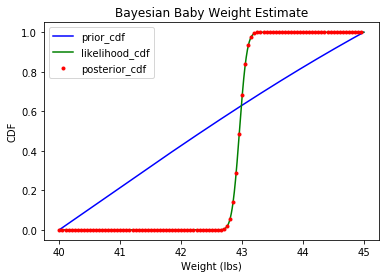

In [10]:
year_5_pdf = pd.DataFrame({'lbs': np.linspace(40, 45, num = 1000)})
year_5_pdf['day'] = max_day
year_5_pdf = year_5_pdf.join(data_girls_percentiles[['day', 'L', 'M', 'S']].set_index('day'), on = 'day')
year_5_pdf['kg'] = lbs_to_kg(lb = year_5_pdf['lbs'])
year_5_pdf['prior_z_score'] = year_5_pdf[['kg', 'L', 'M', 'S']].apply(axis = 1,
                                                                    func = lambda in_row: 
                                                                    LMS_z_score(weight_kg = in_row['kg'],
                                                                                L = in_row['L'],
                                                                                M = in_row['M'], 
                                                                                S = in_row['S']))
for colname in ['L', 'M', 'S', 'kg']:
    del year_5_pdf[colname]

year_5_pdf['likelihood_z_score'] = (year_5_pdf['prior_z_score'] - likelihood_mean) / likelihood_stdev
year_5_pdf['prior_pdf'] = scipy.stats.norm.pdf(x = year_5_pdf['prior_z_score'], loc=0, scale=1)
year_5_pdf['likelihood_pdf'] = scipy.stats.norm.pdf(x = year_5_pdf['likelihood_z_score'], loc=0, scale=1)
year_5_pdf['posterior_pdf'] = year_5_pdf['prior_pdf'] * year_5_pdf['likelihood_pdf']
year_5_pdf['prior_cdf'] = year_5_pdf['prior_pdf'].cumsum(axis = 0)
year_5_pdf['likelihood_cdf'] = year_5_pdf['likelihood_pdf'].cumsum(axis = 0)
year_5_pdf['posterior_cdf'] = year_5_pdf['posterior_pdf'].cumsum(axis = 0)
year_5_pdf['prior_cdf'] = year_5_pdf['prior_cdf'] / np.max(year_5_pdf['prior_cdf'])
year_5_pdf['likelihood_cdf'] = year_5_pdf['likelihood_cdf'] / np.max(year_5_pdf['likelihood_cdf'])
year_5_pdf['posterior_cdf'] = year_5_pdf['posterior_cdf'] / np.max(year_5_pdf['posterior_cdf'])

### check max posterior
print("Max posterior: "+ str(np.max(year_5_pdf['posterior_pdf'])))

plt.plot(year_5_pdf['lbs'], year_5_pdf['prior_cdf'], label = 'prior_cdf',
        linestyle = '-', color = 'b')
plt.plot(year_5_pdf['lbs'], year_5_pdf['likelihood_cdf'], label = 'likelihood_cdf',
        linestyle = '-', color = 'g')
plt.plot(year_5_pdf['lbs'].iloc[lambda x: x.index % 10 == 0], 
         year_5_pdf['posterior_cdf'].iloc[lambda x: x.index % 10 == 0], 
         label = 'posterior_cdf',
        linestyle = 'None', marker = '.', color = 'r')

plt.xlabel('Weight (lbs)')
plt.ylabel('CDF')
plt.title('Bayesian Baby Weight Estimate')
plt.legend()
plt.show()

## Start MCMC
Approximate same posterior with MCMC

In [11]:
max_posterior_lbs

42.91891891891892

In [48]:
iteration = [0]
MCMC_lbs = [max_posterior_lbs]
MCMC_day = max_day
MCMC_L = data_girls_percentiles.loc[data_girls_percentiles['day'] == MCMC_day]['L'].iloc[0]
MCMC_M = data_girls_percentiles.loc[data_girls_percentiles['day'] == MCMC_day]['M'].iloc[0]
MCMC_S = data_girls_percentiles.loc[data_girls_percentiles['day'] == MCMC_day]['S'].iloc[0]
MCMC_prior_z_score = [LMS_z_score(weight_kg = lbs_to_kg(lb = MCMC_lbs[0]), 
                                  L = MCMC_L, M = MCMC_M, S = MCMC_S)]
MCMC_likelihood_z_score = [(MCMC_prior_z_score[0] - likelihood_mean) / likelihood_stdev]
MCMC_prior_pdf = [scipy.stats.norm.pdf(x = MCMC_prior_z_score[0], loc=0, scale=1)]
MCMC_likelihood_pdf = [scipy.stats.norm.pdf(x = MCMC_likelihood_z_score[0], loc=0, scale=1)]  
MCMC_posterior_pdf = [MCMC_prior_pdf[0] * MCMC_likelihood_pdf[0]]
MCMC_alpha = [MCMC_posterior_pdf]

In [49]:
for i in range(1, 30000):
    MCMC_lbs.append(MCMC_lbs[i - 1] + (np.random.uniform(-1.0, 1.0) * 10))
    MCMC_prior_z_score.append(LMS_z_score(weight_kg = lbs_to_kg(lb = MCMC_lbs[i]), 
                                          L = MCMC_L, M = MCMC_M, S = MCMC_S))
    MCMC_likelihood_z_score.append((MCMC_prior_z_score[i] - likelihood_mean) / likelihood_stdev)
    MCMC_prior_pdf.append(scipy.stats.norm.pdf(x = MCMC_prior_z_score[i], loc=0, scale=1))
    MCMC_likelihood_pdf.append(scipy.stats.norm.pdf(x = MCMC_likelihood_z_score[i], loc=0, scale=1))
    MCMC_posterior_pdf.append(MCMC_prior_pdf[i] * MCMC_likelihood_pdf[i])
    if MCMC_posterior_pdf[i] == 0:
        MCMC_alpha.append(0)
    elif MCMC_posterior_pdf[i - 1] == 0:
        MCMC_alpha.append(2)
    else:
        MCMC_alpha.append(MCMC_posterior_pdf[i] / MCMC_posterior_pdf[i - 1])
    if MCMC_alpha[i] < 1:
        if np.random.uniform(0, 1) > MCMC_alpha[i]:
            MCMC_lbs[i] = MCMC_lbs[i - 1]
            MCMC_prior_z_score[i] = MCMC_prior_z_score[i - 1]
            MCMC_likelihood_z_score[i] = MCMC_likelihood_z_score[i - 1]
            MCMC_prior_pdf[i] = MCMC_prior_pdf[i - 1]
            MCMC_likelihood_pdf[i] = MCMC_likelihood_pdf[i - 1]
            MCMC_posterior_pdf[i] = MCMC_posterior_pdf[i - 1]
            MCMC_alpha[i] = MCMC_alpha[i - 1]

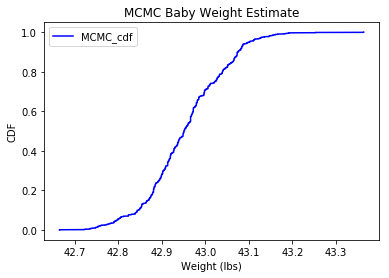

In [50]:
MCMC_results = pd.DataFrame({'MCMC_lbs': MCMC_lbs}).sort_values('MCMC_lbs')
MCMC_results['cdf'] = list(range(MCMC_results.shape[0]))
MCMC_results['cdf'] = (MCMC_results['cdf'] + 1) / MCMC_results.shape[0]
#MCMC_results
plt.plot(MCMC_results['MCMC_lbs'], MCMC_results['cdf'], label = 'MCMC_cdf',
        linestyle = '-', color = 'b')
plt.xlabel('Weight (lbs)')
plt.ylabel('CDF')
plt.title('MCMC Baby Weight Estimate')
plt.legend()
plt.show()